In [51]:
from typing import List, Optional

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as ss
import seaborn as sns
from datetime import date, datetime

In [52]:
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [53]:
print(f'No. of rows originally: {data.shape[0]}')

No. of rows originally: 2240


In [54]:
# drops the column ID, ignores if already dropped (does not raise error)
data = data.drop('ID', axis=1, errors='ignore')

# Replace the birth year with an age field
data['Year_Birth'] = date.today().year - data['Year_Birth']
data.rename(columns={'Year_Birth': 'Age'}, inplace=True)
data.columns

Index(['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [55]:
# number of people with age > 100 is 3
print(data['Age'].where(data['Age'] > 100).count())
data = data[data['Age'] < 100]
data.shape

3


(2237, 28)

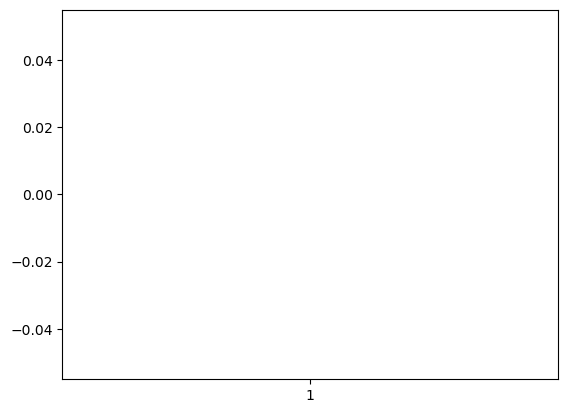

In [78]:
# Plot the distribution of a column to visualize the outliers
plt.boxplot(data['Income'])
plt.show()

- As suspected, age and response have $0$ correlation with each other, therefore we will drop that column. 
- We will do a similar thing, with `Dt_Customer`.

In [58]:
datetime.strptime("04-09-2012", '%d-%m-%Y')

datetime.datetime(2012, 9, 4, 0, 0)

In [59]:
from dateutil.relativedelta import relativedelta
data['Dt_Customer'] = data['Dt_Customer'].apply(lambda x: relativedelta(datetime.now(), datetime.strptime(x, '%d-%m-%Y')).years)
data.rename(columns={'Dt_Customer': 'Customer_Years'}, inplace=True)

<AxesSubplot:>

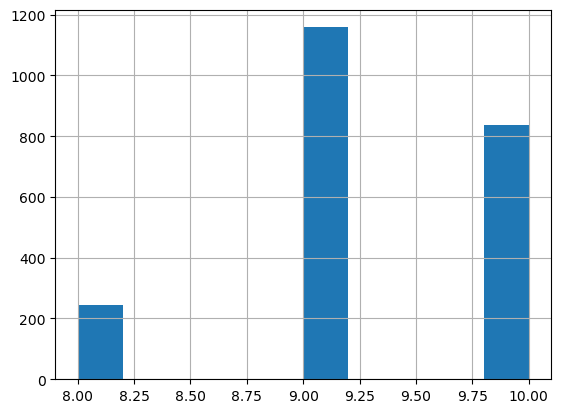

In [60]:
data.Customer_Years.hist()

In [61]:
data[['Customer_Years', 'Response']].corr()

,Customer_Years,Response
Customer_Years,1.000000,0.172851
Response,0.172851,1.000000


In [62]:
# print(data[['Kidhome', 'Response']].corr())

# # since correlation is not much, we drop it
# data = data.drop(columns=['Kidhome'], errors='ignore')

In [63]:
# Replace values like Alone, Absurd, YOLO with Single
data['Marital_Status'] = data['Marital_Status'].where(~data['Marital_Status'].isin(('Alone', 'Absurd', 'YOLO')), 'Single')
print(data['Marital_Status'].value_counts())

Married     864
Together    579
Single      486
Divorced    231
Widow        77
Name: Marital_Status, dtype: int64


In [64]:
data.columns

Index(['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Customer_Years', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [65]:
# Collapse all AcceptedCmp and Response columns into 1, so that if it is accepted even once, 
# it will give True in Accepted field
collapse_target_fields = [f'AcceptedCmp{i}' for i in range(1, 6)] + ['Response']
data = data.assign(Accepted= lambda x: x.AcceptedCmp1 + x.AcceptedCmp2 + x.AcceptedCmp3 + x.AcceptedCmp4 + x.Response > 0)

data = data.drop(columns=collapse_target_fields)

print(data['Accepted'].value_counts())
print(data.columns)

False    1666
True      571
Name: Accepted, dtype: int64
Index(['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Customer_Years', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Accepted'],
      dtype='object')


In [74]:
print( data['Z_CostContact'].value_counts() )
print( data['Z_Revenue'].value_counts() )

data = data.drop(columns=['Z_CostContact', 'Z_Revenue'])

3    2237
Name: Z_CostContact, dtype: int64
11    2237
Name: Z_Revenue, dtype: int64


<AxesSubplot:>

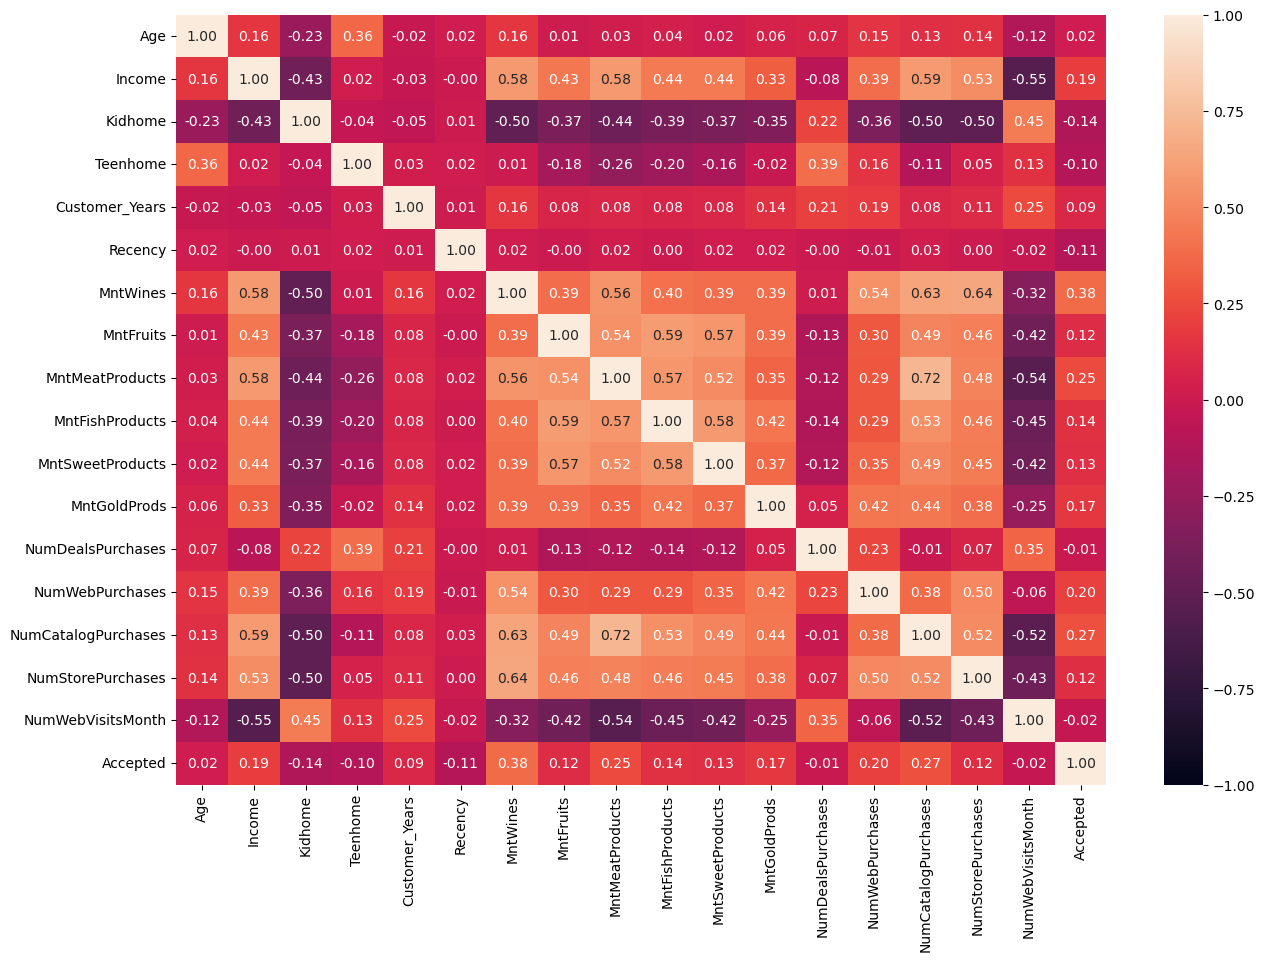

In [66]:
def get_continuous_corr(df: pd.DataFrame, cols: List[str]):
  """
    df: `Dataframe` that we will compute the correlations from
    cols: `List[str]`. Contains the continuous columns that will give us the matrix of correlations
  """

  sub_df = df[cols]
  return sub_df.corr()


cols = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Customer_Years', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
        'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
        'NumStorePurchases', 'NumWebVisitsMonth', 'Accepted']

continuous_corr = get_continuous_corr(data, cols)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(continuous_corr, vmin=-1, vmax=1, annot=True, fmt='.2f', ax=ax)

In [67]:
data = data.drop(columns=['Age', 'NumDealsPurchases', 'NumWebVisitsMonth'])
data.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Customer_Years', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Accepted'],
      dtype='object')

In [13]:
from collections import Counter
import math


def conditional_entropy(x, y):
  # entropy of x given y
  y_counter = Counter(y)
  xy_counter = Counter(list(zip(x, y)))
  total_occurrences = sum(y_counter.values())
  entropy = 0
  for xy in xy_counter.keys():
    p_xy = xy_counter[xy] / total_occurrences
    p_y = y_counter[xy[1]] / total_occurrences
    entropy += p_xy * math.log(p_y/p_xy)
  return entropy


def theil_u(x, y):
  s_xy = conditional_entropy(x, y)
  x_counter = Counter(x)
  total_occurrences = sum(x_counter.values())
  p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
  s_x = ss.entropy(p_x)
  if s_x == 0:
    return 1
  else:
    return (s_x - s_xy) / s_x

- If customer has accepted campaign in 1st try, that does not mean he cannot accept it again in subsequent tries.
- Therefore, we will first check the levels of correlation for all categorical variables with only `Response` and then if we combine all of the `AcceptedCmp` and `Response` columns together.

In [20]:
theil_u(data['Response'].tolist(), data['AcceptedCmp1'].tolist())

0.07237646525721897

In [25]:
(data['AcceptedCmp'] * data['Response'] == 1).value_counts()

False    2148
True       92
dtype: int64

In [13]:
data.isnull().sum()

Education               0
Marital_Status          0
Income                 24
Teenhome                0
Customer_Years          0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

**Only income has NULL values**

In [31]:
incomes = data['Income'].to_numpy()
np.nanmin(incomes), np.nanmax(incomes)

(1730.0, 666666.0)

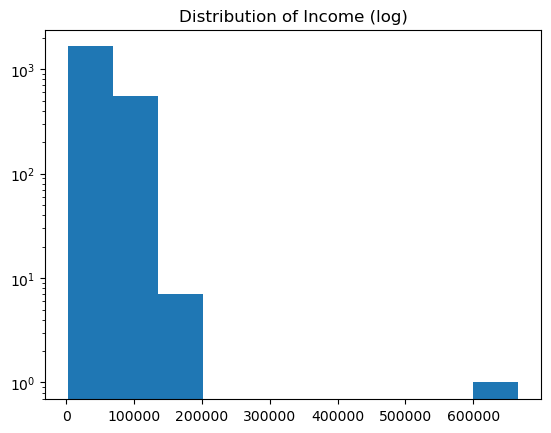

In [38]:
plt.title('Distribution of Income (log)')
plt.hist(incomes, log=True) ;

In [31]:
# data['Income'] = data['Income'].fillna(data['Income'].median())
print(f'Initial number of rows: {data.shape[0]}')
data = data.dropna()
print(f'Final number of rows: {data.shape[0]}')
data.isnull().sum()

Initial number of rows: 2216
Final number of rows: 2216


Education              0
Marital_Status         0
Income                 0
Teenhome               0
Customer_Years         0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [58]:
# gets distribution of education in the dataset
educations = data['Education'].value_counts(normalize=True)
educations

Graduation    0.503125
PhD           0.216964
Master        0.165179
2n Cycle      0.090625
Basic         0.024107
Name: Education, dtype: float64

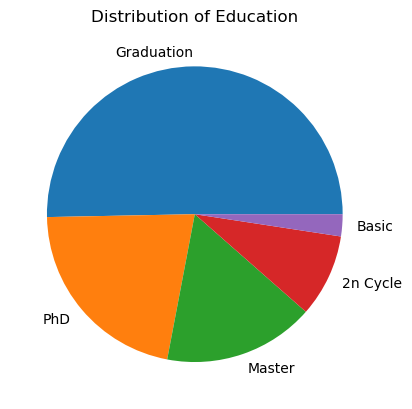

In [60]:
def plot_series_pie(series: pd.Series, plot_title=None):
  """`series` should be normalised"""

  series = series * 100
  keys = series.keys()

  if plot_title:
    plt.title(plot_title)

  plt.pie(series, labels=keys)

plot_series_pie(educations, 'Distribution of Education')

In [75]:
pd.get_dummies(data['Education'])

,2n Cycle,Basic,Graduation,Master,PhD
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,1
...,...,...,...,...,...
2235,0,0,1,0,0
2236,0,0,0,0,1
2237,0,0,1,0,0
2238,0,0,0,1,0


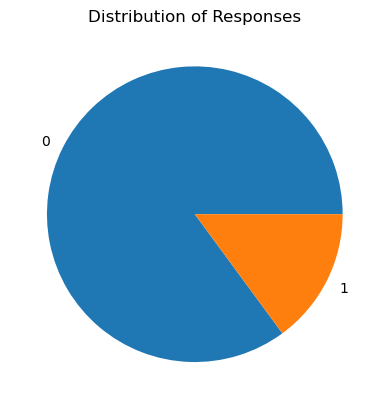

In [66]:
plot_series_pie(data['Response'].value_counts(True), 'Distribution of Responses')

KeyError: 4